# Goats Versus Gravity - Exploring Embeddings

_Author_: Phil Miesle, [DataStax](https://datastax.com/), phil.miesle@datastax.com

![Goats walking on a near-vertical dam](image.png)

## Introduction and Overview
Vector embeddings are a numeric representation of something like text, images, sound, or really anything that has real-world meaning. The meaning of that object is "captured" within the numbers, but it is difficult for we mortal humans to understand numeric data...particuarly data that has hundreds or thousands or more dimensions.

The purpose of this notebook is to show you a common technique for making sense of high-dimension data, and crucically allowing you to see the relationships between data within that dataset.

You will learn how to use a technique called [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to visualize the relationships between the embeddings of four scientific papers. You will then create an interactive graph that can allow you to see the "real data" behind each data point, and compare the cosine similarity between any two points.

You will also learn how you can visualize your own text against this vector space.

These techniques should help you to gain a better understanding of how vector embeddings are useful to finding related data, and how you can use them to refine your application design and parameters.

### The Papers

In this notebook, we will explore some text embeddings of four scientific papers:

1. [LIGO: The Laser Interferometer Gravitational-Wave Observatory](https://arxiv.org/pdf/0711.3041.pdf)
2. [Livestock as a potential biological control agent for an invasive wetland plant](https://peerj.com/articles/567/)
3. [Quantum black holes as classical space factories](https://arxiv.org/abs/2308.15519)
4. [Effects of Invasive Goats (Capra hircus) on Mediterranean Island Communities](https://deepblue.lib.umich.edu/handle/2027.42/117674)

The title of the notebook should, at this point, be self-evident. We will be comparing two scientific papers about goats with two scientific papers about gravity.

These have been pre-processed, with the title and the next 31 paragraphs of each paper extracted. That text has been further processed to remove a number of references like `[3]`; the text therefore fairly "clean", and in concept each format is a semantic unit. You can view the raw text in the `data` directory (these are the `.txt` files).

From here, OpenAI embeddings were computed using `text-embedding-ada-002`, and saved in a Pandas dataframe. This notebook will start from that point, but you are welcome to explore the data preparation by looking at [ingestion.ipynb](ingestion.ipynb).

## What You Need To Start
This notebook is fairly light on requirements - you need to install only what is in [requirements.txt](requirements.txt). You can do this with `pip install -r requirements.txt`.

You do not need any other external service or subscription.

## Load The Data

In [1]:
import pandas as pd
df_all = pd.read_pickle('data/text.pkl')
print(df_all.groupby('type').count())

               text  openaiEmbeddings
type                                 
blackholes       32                32
goats            32                32
gravity          32                32
invasivegoats    32                32


## Visualizing the Embeddings in Two Dimensions

### Using a Heatmap

We can compute cosine similarity between two vectors - those with higher cosine simliarity will have a similarity score closer to a value of `1`, and those that are completely unrelated will have a cosine similarity value of `-1`.

We will take two of the papers from the dataset, and compute the cosine similarity between each of the paragraphs in the first paper, and each of the paragraphs in the second paper. We will then visualize the results in a heatmap.


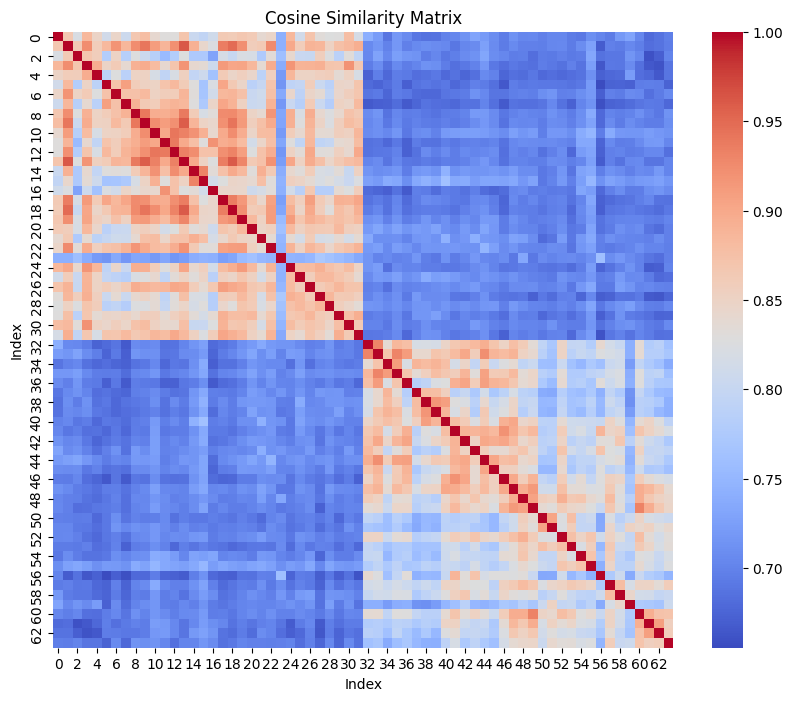

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

df = df_all[df_all['type'].isin(['goats', 'gravity'])]

# Stack the embeddings into a 2D numpy array
embeddings_2d = np.stack(df['openaiEmbeddings'].values)

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_2d)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='coolwarm')
plt.title("Cosine Similarity Matrix")
plt.xlabel("Index")
plt.ylabel("Index")
plt.show()

A few things to note from this heatmap:

1. There is a diagnonal - of course we would expect that a paragraph would be most similar to itself, and the cosine similarity should be `1`.
2. We can see two "blocks" of similiarity. The `goats` paper is at Index 0 to 31, and the `gravity` paper is at Index 32 to 63. We might expect that paragaphs in each paper would be more similar to each other, hence the more "red" hues on those corners.
3. The two blocks of blue are one paper's paragraphs related to the other; that they are blue reflects a general dissimilarity. 
4. Paragraphs within the `goats` paper seem to be more similar to each other than the paragraphs in the `gravity` paper relate to each other. This is reflected in the more "red" hues in the `goats` block.
5. In the `goats` paper, there is a cluster of similarity around Index 8-12.

But also note that the minimum cosine similiarty here is more than `0.65` - that is, even the least similar paragraphs in these two papers seem like they are more "similar" than we might expect!

### Using t-SNE

We can run a t-SNE (t-distributed Stochastic Neighbor Embedding) analysis to project the high-dimensionality space into two dimensions; this can be useful for visualizing clustering in the embeddings as a 64x64 heatmap is not very easy to interpret!

c:\Users\Phil\git\GoatsVGravity\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Phil\git\GoatsVGravity\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


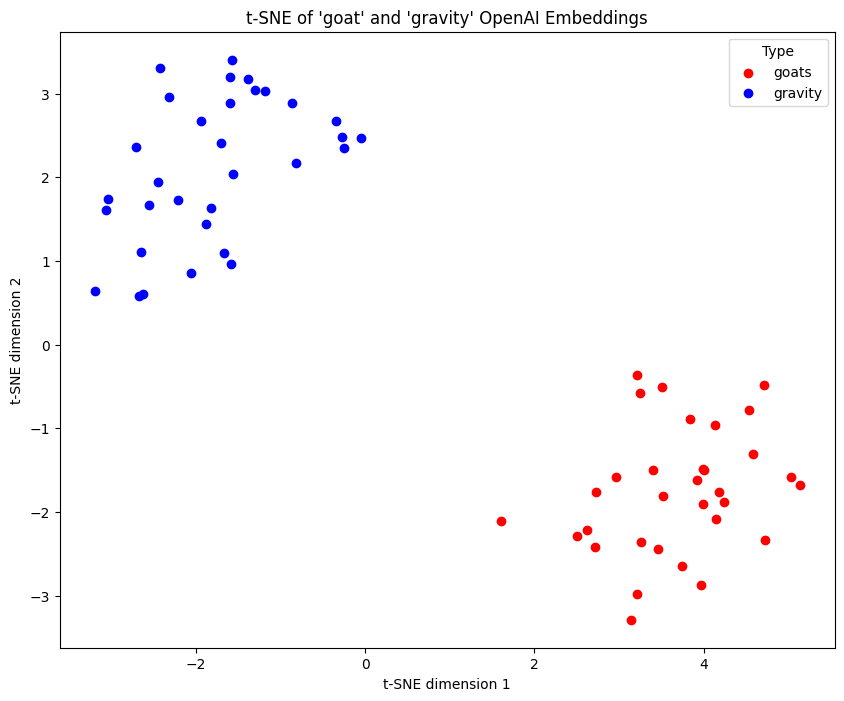

In [3]:
from sklearn.manifold import TSNE

# Converting the list of embeddings to a numpy array
embeddings_matrix = np.array(df['openaiEmbeddings'].tolist())

# Perform t-SNE
random_seed=123
tsne = TSNE(n_components=2, random_state=random_seed, init='random')
embeddings_tsne = tsne.fit_transform(embeddings_2d)

# Create a DataFrame for the t-SNE results and labels
df_tsne = pd.DataFrame(embeddings_tsne, columns=['x', 'y'])
df_tsne['type'] = df['type'].values

# Plot t-SNE results with labels
plt.figure(figsize=(10, 8))
for category, color in zip(['goats', 'gravity'], ['red', 'blue']):
    points = df_tsne[df_tsne['type'] == category]
    plt.scatter(points['x'], points['y'], c=color, label=category)
plt.title("t-SNE of 'goat' and 'gravity' OpenAI Embeddings")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title='Type')
plt.show()


The t-SNE shows us that we have two clusters of paragraphs, one for each paper. We can also see that the paragraphs in the `goats` paper are more similar to each other than the paragraphs in the `gravity` paper - the cluster of blue dots is quite separate from the cluster of red dots. 

One of the nice things about t-SNE is that it allows us to contemplate clustering of more than just two vectors. Our `goats` paper discusses the effects of using goats to control invasive species, whereas the `gravtiy` paper discusses the LIGO gravity wave detector. But we have two other papers for which we have embeddings: the `invasivegoats` paper discusses goats as an invasive species, and the `blackholes` paper talks about how quantum field theory can join space and matter.

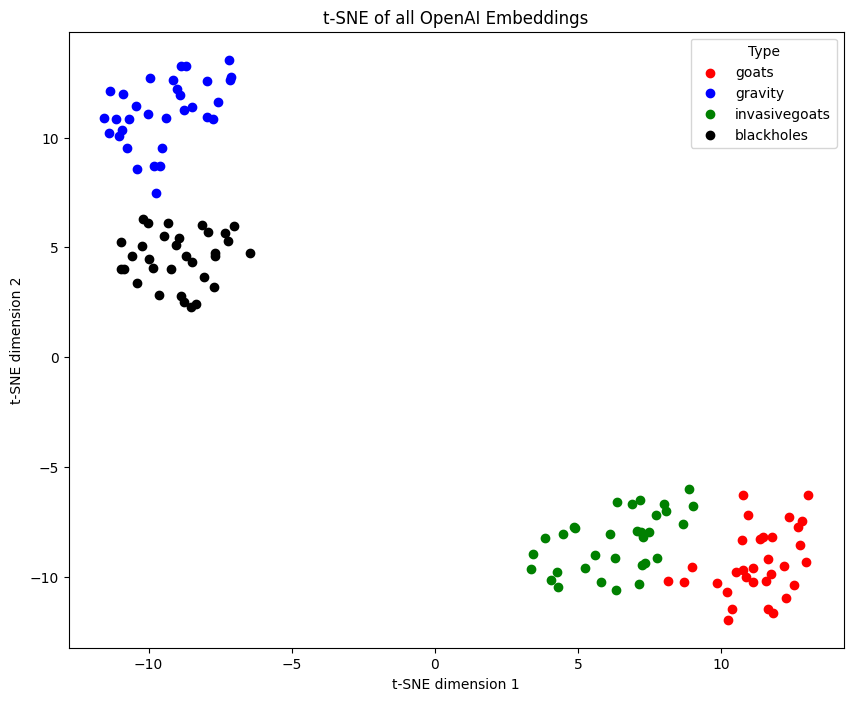

In [4]:
# Stack the embeddings into a 2D numpy array
embeddings_2d = np.stack(df_all['openaiEmbeddings'].values)

# Perform t-SNE
random_seed=123
tsne = TSNE(n_components=2, random_state=random_seed, init='random')
embeddings_tsne = tsne.fit_transform(embeddings_2d)

# Create a DataFrame for the t-SNE results and labels
df_tsne = pd.DataFrame(embeddings_tsne, columns=['x', 'y'])
df_tsne['type'] = df_all['type'].values

# Plot t-SNE results with labels
plt.figure(figsize=(10, 8))
for category, color in zip(['goats', 'gravity', 'invasivegoats', 'blackholes'], ['red', 'blue','green','black']):
    points = df_tsne[df_tsne['type'] == category]
    plt.scatter(points['x'], points['y'], c=color, label=category)
plt.title("t-SNE of all OpenAI Embeddings")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title='Type')
plt.show()

Here we see that our `goats` and `invasivegoats` papers are closer to each other than they are to `gravity` and `blackholes`, but that we have distinctive clusters for each paper. This is a good sign that our embeddings are capturing some of the semantic meaning of the text.

A different embedding model might give us different results, we will explore that next.

## A Different Embedding Model

Let's see what happens if we use a different embedding model. We'll use [Sentence-Transformers](https://www.sbert.net/) from [SBERT.net](https://www.sbert.net) as it runs fairly quickly on a CPU:

In [5]:
from sentence_transformers import SentenceTransformer
# Consider other models at https://www.sbert.net/docs/pretrained_models.html including all-mpnet-base-v2 and distiluse-base-multilingual-cased-v2
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
 
def get_sentence_embedding(sentence):
    return model.encode([sentence])[0]

df_all['stEmbeddings'] = df_all['text'].apply(get_sentence_embedding)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   type              128 non-null    object
 1   text              128 non-null    object
 2   openaiEmbeddings  128 non-null    object
 3   stEmbeddings      128 non-null    object
dtypes: object(4)
memory usage: 4.1+ KB


So now that we've added a new column of embeddings to our data model, what does the clustering look like for them?

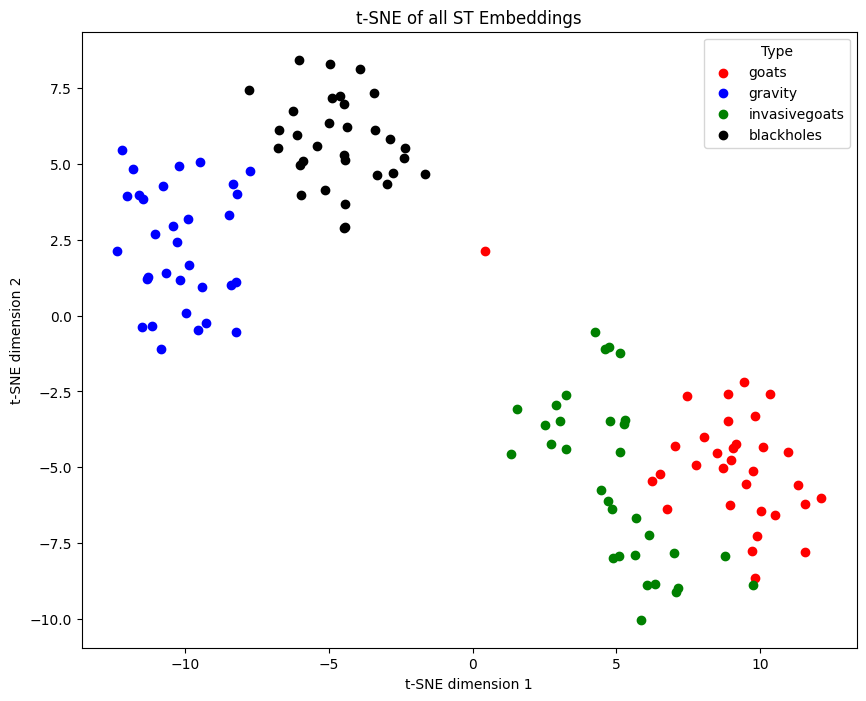

In [6]:
# Stack the embeddings into a 2D numpy array
embeddings_2d = np.stack(df_all['stEmbeddings'].values)

# Perform t-SNE
random_seed=123
tsne = TSNE(n_components=2, random_state=random_seed, init='random')
embeddings_tsne = tsne.fit_transform(embeddings_2d)

# Create a DataFrame for the t-SNE results and labels
df_tsne = pd.DataFrame(embeddings_tsne, columns=['x', 'y'])
df_tsne['type'] = df_all['type'].values

# Plot t-SNE results with labels
plt.figure(figsize=(10, 8))
for category, color in zip(['goats', 'gravity', 'invasivegoats', 'blackholes'], ['red', 'blue','green','black']):
    points = df_tsne[df_tsne['type'] == category]
    plt.scatter(points['x'], points['y'], c=color, label=category)
plt.title("t-SNE of all ST Embeddings")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title='Type')
plt.show()

You can try different ST [pre-trained models](https://www.sbert.net/docs/pretrained_models.html) to see how these affect the clustering. What we see with the `paraphrase-MiniLM-L6-v2` model is that the papers are still fairly distinct though less compact, and the `goats` and `invasivegoats` are closer to each other. There is also a curious `goats` outlier that is in the "void"! What in the world is in that point?!?

## Interactive t-SNE

Let's use the Plotly library, as this allows us to do some tooltips - these can reveal the underlying text when you hover over a point.

In [8]:
import plotly.graph_objs as go

def wrap_text(text, max_len=100):
    words = text.split()
    lines = []
    current_line = ""

    for word in words:
        if len(current_line) + len(word) + 1 > max_len:  # +1 accounts for a space
            lines.append(current_line)
            current_line = word
        else:
            if current_line:
                current_line += " " + word
            else:
                current_line = word

    lines.append(current_line)

    return "<br>".join(lines)

# Add 'text' from the original df_all DataFrame to the df_tsne DataFrame
df_tsne['wrapped_text'] = df_all['text'].apply(wrap_text)
df_tsne['i'] = df_tsne.index

# Define the custom color map
color_map = {'goats': 'red', 'gravity': 'blue', 'invasivegoats': 'green', 'blackholes': 'black'}

traces = []
for category, color in color_map.items():
    filtered_df = df_tsne[df_tsne['type'] == category]
    
    trace = go.Scatter(
        x=filtered_df['x'],
        y=filtered_df['y'],
        mode='markers',
        marker=dict(
            color=color,  # color for this category
            size=10  # set all sizes to 10
        ),
        customdata=filtered_df[['i', 'wrapped_text']],
        hovertemplate="i: %{customdata[0]}<br>%{customdata[1]}",
        name=category  # Name for the legend
    )
    
    traces.append(trace)

# Create layout
layout = go.Layout(
    title='t-SNE of all ST Embeddings',
    xaxis=dict(title='t-SNE dimension 1'),
    yaxis=dict(title='t-SNE dimension 2'),
    width=1200,
    height=800,
)

# Create FigureWidget
fig = go.FigureWidget(data=traces, layout=layout)

# Display the figure
fig

FigureWidget({
    'data': [{'customdata': array([[0,
                                    'Livestock as a potential biological control agent for an invasive wetland plant'],
                                   [1,
                                    'Invasive species threaten biodiversity and incur costs exceeding billions of US$. Eradication<br>efforts, however, are nearly always unsuccessful. Throughout much of North America, land managers<br>have used expensive, and ultimately ineffective, techniques to combat invasive Phragmites australis<br>in marshes. Here, we reveal that Phragmites may potentially be controlled by employing an affordable<br>measure from its native European range: livestock grazing. Experimental field tests demonstrate that<br>rotational goat grazing (where goats have no choice but to graze Phragmites) can reduce Phragmites<br>cover from 100 to 20% and that cows and horses also readily consume this plant. These results,<br>combined with the fact that Europeans hav

So that is helpful right? We can now hover over a point and see the text (and dataframe index) that is associated with that point. Turns out it is a table caption from the `goats` paper ("Table 1 Management Considerations") - on its own, not semantically similar to a research paper about goats! Good job embeddings!

But now consider that we're looking at a 2D t-SNE projection. By the nature of such a projection, it is distorting the real similarity of the points to each other in high-dimensional space. Still really useful - consider we now have four points, and a heatmap of these would be some sort of four-dimensional cube that we couldn't really visualize!

What we probably *really* want to understand is "how similar" is one point compared to another...understanding that those whcih are closer together have higher similarity to each other than points further apart.

Let's enhance our interactive t-SNE to show a cosine similarity score relative to a point that we have clicked (we're going to wrap this in a function for reasons that will become apparent in the next part):

In [9]:
active_point = None
def plot_interactive_tsne(df, embeddings_col, color_map):
    
    # First compute a TSNE and get a dataframe
    embeddings_2d = np.stack(df[embeddings_col].values)

    # Perform t-SNE
    random_seed=123
    tsne = TSNE(n_components=2, random_state=random_seed, init='random')
    embeddings_tsne = tsne.fit_transform(embeddings_2d)

    # Create a DataFrame for the t-SNE results and labels
    df_copy = pd.DataFrame(embeddings_tsne, columns=['x', 'y'])
    df_copy['type'] = df['type'].values    
    df_copy['embeddings'] = df[embeddings_col].values
    df_copy['wrapped_text'] = df['text'].apply(wrap_text)
    df_copy['i'] = df_copy.index
    df_copy['cosine_similarity'] = None
    
    layout = go.Layout(
        title='t-SNE of Embeddings',
        xaxis=dict(title='t-SNE dimension 1'),
        yaxis=dict(title='t-SNE dimension 2'),
        width=1200,
        height=800)
    
    unlabelled_types = []
    traces = []
    for category in df_copy['type'].unique():
        filtered_df = df_copy[df_copy['type'] == category]
        color = color_map.get(category, None)
        if color is None:
            unlabelled_types.append(category)
            continue
        
        trace = go.Scatter(
            x=filtered_df['x'],
            y=filtered_df['y'],
            mode='markers',
            marker=dict(
                color=color,
                size=10,
                line=dict(
                    width=0,  # No border
                    color='rgba(0, 0, 0, 0)'  # Transparent
                )      
            ),
            hoverinfo='text',
            customdata=filtered_df['i'],
            name=category
        )    
        traces.append(trace)

    # Create a trace for unlabelled types
    if unlabelled_types:
        filtered_df = df_copy[df_copy['type'].isin(unlabelled_types)]
        trace = go.Scatter(
            x=filtered_df['x'],
            y=filtered_df['y'],
            mode='markers',
            marker=dict(
                color='lightgrey',
                size=10,
                line=dict(
                    width=0,  # No border
                    color='rgba(0, 0, 0, 0)'  # Transparent
                )                
            ),
            hoverinfo='text',
            customdata=filtered_df['i'],
            name='unlabelled'
        )
        traces.append(trace)

    fig = go.FigureWidget(
        data=traces,
        layout=layout
    )

    # Initialize hover texts
    for trace in fig.data:
        current_trace_df = df_copy[df_copy['type'] == trace.name] if trace.name != 'unlabelled' else df_copy[df_copy['type'].isin(unlabelled_types)]        
        trace.hovertext = [f"i: {i}<br>type: {type}<br>{text}" for i, type, text in zip(current_trace_df['i'],
                                                                                        current_trace_df['type'],
                                                                                        current_trace_df['wrapped_text'])]

    def calculate_cosine_similarity(idx):
        active_point_features = np.array(df_copy.loc[idx, 'embeddings']).reshape(1, -1)
        all_features = np.vstack(df_copy['embeddings'].values)
        similarities = cosine_similarity(active_point_features, all_features)[0]
        df_copy['cosine_similarity'] = similarities

    # Update function
    def update_point(trace, points, selector):
        global active_point  # access the global variable
        if points.point_inds:
            active_idx = trace.customdata[points.point_inds[0]]
        else:
            active_idx = None
            
        # If an active point exists and is the clicked point, deactivate it
        if active_point == active_idx:
            active_point = None
            for trace in fig.data:
                current_trace_df = df_copy[df_copy['type'] == trace.name] if trace.name != 'unlabelled' else df_copy[df_copy['type'].isin(unlabelled_types)]

                new_colors = current_trace_df['type'].map(color_map).fillna('lightgrey').tolist()
                new_sizes = [10] * len(current_trace_df)
                trace.marker.line.width = [0] * len(current_trace_df)
                trace.marker.line.color = ['rgba(0, 0, 0, 0)'] * len(current_trace_df)
                trace.marker.color = new_colors
                trace.marker.size = new_sizes

                new_hover_texts = [f"i: {i}<br>type: {type}<br>{text}" 
                                for i, type, text in zip(current_trace_df['i'], 
                                                         current_trace_df['type'], 
                                                         current_trace_df['wrapped_text'])]
                trace.hovertext = new_hover_texts            

            df_copy['cosine_similarity'] = None
            return

        # Otherwise, set the clicked point as the active point
        if active_idx is not None:
            calculate_cosine_similarity(active_idx)
            active_point = active_idx
            for trace in fig.data:
                current_trace_df = df_copy[df_copy['type'] == trace.name] if trace.name != 'unlabelled' else df_copy[df_copy['type'].isin(unlabelled_types)]
                new_colors = current_trace_df['type'].map(color_map).fillna('lightgrey').tolist()
                new_sizes = [10] * len(current_trace_df)
                new_widths = [0] * len(current_trace_df)
                new_line_colors = ['rgba(0, 0, 0, 0)'] * len(current_trace_df)

                if active_point in current_trace_df.index:
                    new_colors[current_trace_df.index.get_loc(active_point)] = 'yellow'
                    new_sizes[current_trace_df.index.get_loc(active_point)] = 20
                    new_widths[current_trace_df.index.get_loc(active_point)] = 1
                    new_line_colors[current_trace_df.index.get_loc(active_point)] = 'black'
                else:
                    new_colors = current_trace_df['type'].map(color_map).fillna('lightgrey').tolist()
                    new_sizes = [10] * len(current_trace_df)
                    new_widths = trace.marker.line.width = [0] * len(current_trace_df)
                    new_line_colors = trace.marker.line.color = ['rgba(0, 0, 0, 0)'] * len(current_trace_df)
                
                trace.marker.color = new_colors
                trace.marker.size = new_sizes
                trace.marker.line.width = new_widths
                trace.marker.line.color = new_line_colors
                
                # Correct the hover texts to use the global index
                new_hover_texts = [f"i: {i}<br>type: {type}<br>Cosine similarity to i={active_point}: {cos:.3f}<br>{text}" 
                                for i, type, cos, text in zip(current_trace_df['i'], 
                                                              current_trace_df['type'], 
                                                              current_trace_df['cosine_similarity'], 
                                                              current_trace_df['wrapped_text'])]
                trace.hovertext = new_hover_texts            

    
    for trace in fig.data:
        trace.on_click(update_point)

    return fig

fig = plot_interactive_tsne(df_all, 'stEmbeddings', color_map)
fig

FigureWidget({
    'data': [{'customdata': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64),
              'hoverinfo': 'text',
              'hovertext': [i: 0<br>type: goats<br>Livestock as a potential
                            biological control agent for an invasive wetland plant,
                            i: 1<br>type: goats<br>Invasive species threaten
                            biodiversity and incur costs exceeding billions of US$.
                            Eradication<br>efforts, however, are nearly always
                            unsuccessful. Throughout much of North America, land
                            managers<br>have used expensive, and ultimately
                            ineffective, techniques to combat invasive Phragmites
                            australis<br>in marshes. Here, we reveal that
                        

Click on any point on this plot, and now move over other points. You will see that the similarity score is changing, and that the points that are closer together have higher similarity scores. This is a nice way to explore the similarity of the embeddings. 

You can click on an active point to de-select it, or click on a different point to recompute cosine similarity from that point.

Another handy feature of Plotly charts is you can zoom in by click-and-drag within the chart. The "home" icon at the top right of the plot will reset the axes, and here you will also find some other perhaps useful controls.

What you may find suprising is that points that are very close to each other on the t-SNE may not have as high of a cosine similarity as you might expect. This is because the t-SNE is a projection of a high-dimensional space into two dimensions, and the cosine similarity is computed in the high-dimensional space. So while the t-SNE is a useful visualization, it is not a perfect representation of the underlying similarity.

## Comparing Your Own Text

This fantastic - let us remind ourselves what our tool can now do:

1. It can map many text documents from a high-dimensional space into a two-dimensional plot using t-SNE; points that are close to each other are more similar than points that are further apart.
2. We can hover over any of the points to see "what is that point, in human-relatable terms"
3. We can click on any point, and hover over other points to see the cosine similarity between the two points.

But what we might also want to consider is what our own "search phrases" look like in this space. Let's say we wanted to ask the question "What is the impact of goats on invasive species?" - we can use our embedding model to compute the similarity of that phrase to each of the paragraphs in our dataset, and then plot that similarity on the t-SNE.

But will it work?  Let's see!

### Compute Embeddings for our Search Phrases

Continuing to use the Sentence Transformer model, we can compute embeddings for our search phrases:

In [10]:
search_phrases = [
    "What is the impact of invasive species?",
    "How can we detect gravity waves?",
    "How do goats contribute to controlling invasive species?",
    "Explain the theory of relativity.",  # This theory is related to gravity
    "What is the airspeed velocity of an unladen swallow?", # Monty Python reference, but probably not related to our texts
    "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua?", # jibberish - what happens to this?
]

In [11]:
search_embeddings = [get_sentence_embedding(phrase) for phrase in search_phrases]

search_df = pd.DataFrame({
    'type': 'search',
    'text': search_phrases,
    'openaiEmbeddings' : None,
    'stEmbeddings': search_embeddings,
})

search_df


,type,text,openaiEmbeddings,stEmbeddings
0,search,What is the impact of invasive species?,None,"[0.06202228, -0.11808558, 0.3085978, 0.0552644..."
1,search,How can we detect gravity waves?,None,"[-0.37983906, -0.3218584, 0.108020335, 0.09290..."
2,search,How do goats contribute to controlling invasiv...,None,"[-0.029002456, -0.4858782, 0.56125355, 0.34002..."
3,search,Explain the theory of relativity.,None,"[-0.18222648, -0.3336932, 0.013223447, 0.16855..."
4,search,What is the airspeed velocity of an unladen sw...,None,"[0.024590848, 0.20053412, 0.1291864, 0.2590131..."
5,search,"Lorem ipsum dolor sit amet, consectetur adipis...",None,"[0.06476453, 0.5654452, 0.3049735, -0.19374624..."


And here's why we made a function:

In [12]:
color_map['search'] = '#f714f0'

plot_interactive_tsne(pd.concat([df_all, search_df], ignore_index=True), 'stEmbeddings', color_map)

FigureWidget({
    'data': [{'customdata': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64),
              'hoverinfo': 'text',
              'hovertext': [i: 0<br>type: goats<br>Livestock as a potential
                            biological control agent for an invasive wetland plant,
                            i: 1<br>type: goats<br>Invasive species threaten
                            biodiversity and incur costs exceeding billions of US$.
                            Eradication<br>efforts, however, are nearly always
                            unsuccessful. Throughout much of North America, land
                            managers<br>have used expensive, and ultimately
                            ineffective, techniques to combat invasive Phragmites
                            australis<br>in marshes. Here, we reveal that
                        

Well this is great! We now have a way to:

1. Put a set of labelled embeddings onto a single 2D plot
2. Generate our own embeddings for a search phrase
3. Review the cosine simliarity of our search phrase to each of the labelled embeddings

## What's Next?

In building an application that searches based on embeddings, it is important to have an embedding model that gives good clustering of information. It is also important to understand what is the value for a cosine similarity that represents "close" and "valid". As you can see with this limited embedding space and simple embedding model, the cosine similarity scores that represent "close" are not as high as you might think they should be.

Your specific application parameters are going to depend on some amount of experimentation and understanding of not only the embedding model, but also the input data you are using, and how you are splitting that data into semantic phrases. For example, if you blindly cut on word count boundaries, perhaps your embedding space will be more fragmented than if you are splitting on sentence, paragraph, section, or chapter boundaries. 

This notebook has hopefully given you some ideas and a couple of tecnhiques for exploring your own embedding space. Good luck!